<h3>Import các thư viện cần thiết</h3>

In [1]:
from keras import layers, models
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import os
import shutil
from random import choice

<h3>Load dữ liệu ảnh</h3>

In [4]:
# Đặt đường dẫn thư mục chứa dữ liệu
data_dir = './images'  # Hoặc đặt đường dẫn từ Google Drive

<h3>Tiền xử lí dữ liệu</h3>

In [5]:

def validate_image(file_path):
    try:
        img = Image.open(file_path)  # Mở thử tệp ảnh
        img.verify()  # Kiểm tra tính hợp lệ của ảnh
        return True
    except (IOError, UnidentifiedImageError):
        return False

# Lọc ra những tệp ảnh hợp lệ trước khi tạo generator
valid_filenames = []
invalid_filenames = [] # Danh sách các file không hợp lệ
for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        if validate_image(file_path):  # Kiểm tra xem ảnh có hợp lệ không
            valid_filenames.append(file_path)
        else:
            invalid_filenames.append(file_path)  # Lưu các ảnh không hợp lệ vào danh sách

# In ra số lượng và danh sách các file không hợp lệ
print(f"Số lượng file ảnh không hợp lệ: {len(invalid_filenames)}")
if invalid_filenames:
    print("Danh sách ảnh không hợp lệ:")
    for invalid_file in invalid_filenames:
        print(invalid_file)

# Sau khi lọc, chỉ còn lại các file hợp lệ
print(f"Số lượng file ảnh hợp lệ: {len(valid_filenames)}")

# Cân bằng ảnh
# Định nghĩa ImageDataGenerator trước khi sử dụng cho tập huấn luyện và kiểm tra
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Chia 20% dữ liệu cho tập kiểm tra
)

# Cân bằng ảnh
def balance_classes(data_dir, target_count):
    # Tạo ImageDataGenerator từ các tệp đã lọc hợp lệ
    augment_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if os.path.isdir(class_dir):
            img_files = os.listdir(class_dir)
            current_count = len(img_files)

            if current_count < target_count:
                # Over-sampling: Dùng augmentation để tạo ảnh mới
                print(f"Over-sampling lớp {class_name} từ {current_count} đến {target_count}")
                while len(img_files) < target_count:
                    img_to_copy = choice(img_files)
                    img_path = os.path.join(class_dir, img_to_copy)

                    # Load ảnh và thực hiện augmentation
                    img = Image.open(img_path)
                    img = img.resize((224, 224))  # Resize nếu cần
                    img_array = np.array(img)
                    img_array = np.expand_dims(img_array, 0)  # Thêm 1 chiều batch

                    # Sử dụng generator để tạo ảnh mới
                    for batch in augment_datagen.flow(img_array, batch_size=1):
                        new_img = batch[0]
                        new_img = Image.fromarray((new_img * 255).astype(np.uint8))  # Chuyển từ array về image

                        # Chuyển từ RGBA sang RGB nếu cần thiết
                        if new_img.mode == 'RGBA':
                            new_img = new_img.convert('RGB')

                        new_img_path = os.path.join(class_dir, f"aug_{len(img_files)}_{img_to_copy}")
                        new_img.save(new_img_path)
                        img_files.append(f"aug_{len(img_files)}_{img_to_copy}")
                        break  # Chỉ tạo 1 ảnh mỗi vòng lặp
            elif current_count > target_count:
                # Under-sampling: Xóa ảnh thừa
                print(f"Under-sampling lớp {class_name} từ {current_count} xuống {target_count}")
                while len(img_files) > target_count:
                    img_to_remove = choice(img_files)
                    img_path = os.path.join(class_dir, img_to_remove)
                    os.remove(img_path)
                    img_files.remove(img_to_remove)
            else:
                print(f"Class {class_name} already has {target_count} images")

balance_classes(data_dir, 1500)

Số lượng file ảnh không hợp lệ: 0
Số lượng file ảnh hợp lệ: 9000
Class duong_xi already has 1500 images
Class lan_y already has 1500 images
Class luoi_ho already has 1500 images
Class nha_dam already has 1500 images
Class thuy_tung already has 1500 images
Class van_nien_thanh already has 1500 images


<h3>Chia tập học và tập kiểm thử</h3>

In [6]:
# Định nghĩa kích thước ảnh và batch size trước khi sử dụng
img_size = (224, 224)
batch_size = 28

# Tạo train và validation generators sử dụng đối tượng datagen chính
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)



# Lấy thông tin các nhãn (class)
class_labels = train_generator.class_indices
print("Class labels:", class_labels)

# Xem hình dạng đầu ra của dữ liệu (batch of images, batch of labels)
for images, labels in train_generator:
    print("Batch image shape:", images.shape)
    print("Batch label shape:", labels.shape)
    break

# Tính số bước trên mỗi epoch và mỗi validation
steps_per_epoch = train_generator.samples // batch_size
validation_steps = validation_generator.samples // batch_size

Found 7200 images belonging to 6 classes.
Found 1800 images belonging to 6 classes.
Class labels: {'duong_xi': 0, 'lan_y': 1, 'luoi_ho': 2, 'nha_dam': 3, 'thuy_tung': 4, 'van_nien_thanh': 5}
Batch image shape: (28, 224, 224, 3)
Batch label shape: (28, 6)


<h3>Mô hình số 1</h3>

In [62]:
model = models.Sequential()

# Tầng tích chập đầu tiên
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ hai
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ ba
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng phân loại
model.add(layers.Flatten())  # Làm phẳng dữ liệu từ ma trận 2D thành vector 1D
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(class_labels), activation='softmax'))  # Lớp softmax cho phân loại đa lớp

# Biên dịch mô hình
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Sử dụng cho bài toán phân loại đa lớp
              metrics=['accuracy'])

# In cấu trúc mô hình
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 26, 26, 128)     

In [63]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=9,  # Số epoch bạn có thể tùy chỉnh
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_steps
)



Epoch 1/9
257/257 [==============================] - 61s 235ms/step - loss: 1.2084 - accuracy: 0.5314 - val_loss: 0.7278 - val_accuracy: 0.7528
Epoch 2/9
257/257 [==============================] - 60s 231ms/step - loss: 0.6340 - accuracy: 0.7648 - val_loss: 0.5109 - val_accuracy: 0.8270
Epoch 3/9
257/257 [==============================] - 59s 230ms/step - loss: 0.5375 - accuracy: 0.8009 - val_loss: 0.3914 - val_accuracy: 0.8627
Epoch 4/9
257/257 [==============================] - 59s 229ms/step - loss: 0.4294 - accuracy: 0.8468 - val_loss: 0.3280 - val_accuracy: 0.8878
Epoch 5/9
257/257 [==============================] - 59s 228ms/step - loss: 0.3699 - accuracy: 0.8688 - val_loss: 0.3327 - val_accuracy: 0.8828
Epoch 6/9
257/257 [==============================] - 59s 229ms/step - loss: 0.3430 - accuracy: 0.8802 - val_loss: 0.2750 - val_accuracy: 0.8973
Epoch 7/9
257/257 [==============================] - 59s 230ms/step - loss: 0.3081 - accuracy: 0.8926 - val_loss: 0.2708 - val_accuracy:

In [64]:
model.save('plant_recognition_model_1.h5')

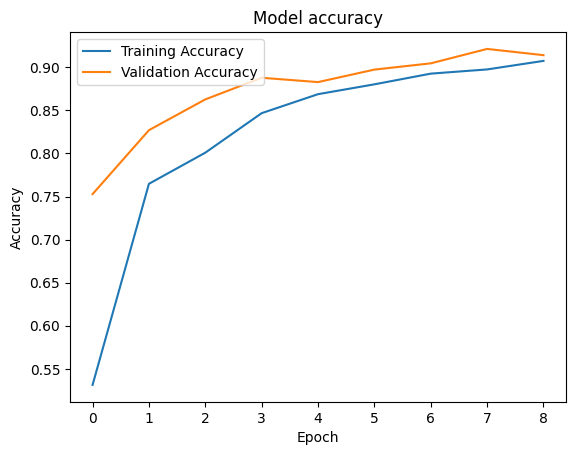

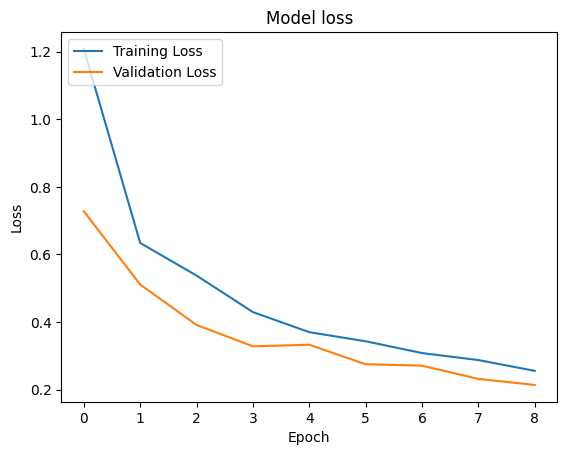

In [66]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot trainingy & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

<h3>Mô hình số 2</h3>

In [4]:
model = models.Sequential()

# Tầng tích chập đầu tiên
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ hai
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ ba
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


# Tầng phân loại
model.add(layers.Flatten())  # Làm phẳng dữ liệu từ ma trận 2D thành vector 1D
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(class_labels), activation='softmax'))  # Lớp softmax cho phân loại đa lớp

# Biên dịch mô hình
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Sử dụng cho bài toán phân loại đa lớp
              metrics=['accuracy'])

# In cấu trúc mô hình
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=9,  # Số epoch bạn có thể tùy chỉnh
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_steps
)


In [81]:
model.save('plant_recognition_model_2.h5')

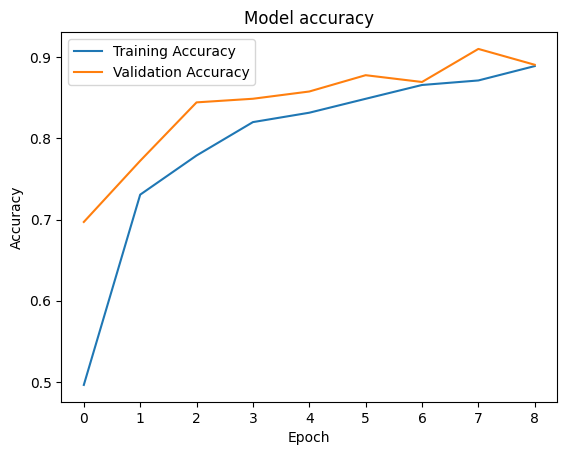

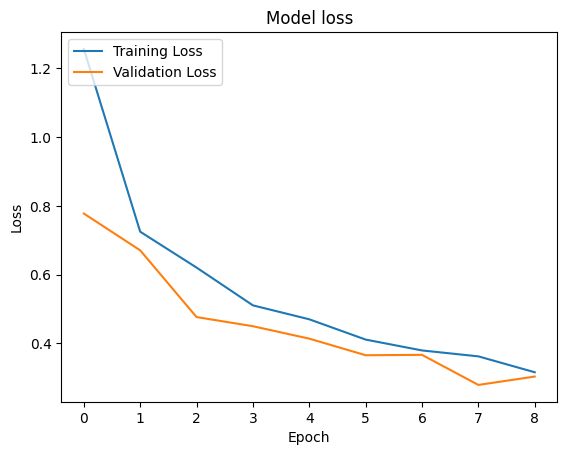

In [82]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot trainingy & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

<h3>Mô hình số 3</h3>

In [15]:
model = models.Sequential()

# Tầng tích chập đầu tiên
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ hai
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ ba
model.add(layers.Conv2D(128, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng phân loại
model.add(layers.Flatten())  # Làm phẳng dữ liệu từ ma trận 2D thành vector 1D
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(class_labels), activation='softmax'))  # Lớp softmax cho phân loại đa lớp

# Biên dịch mô hình
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Sử dụng cho bài toán phân loại đa lớp
              metrics=['accuracy'])

# In cấu trúc mô hình
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 106, 106, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 49, 49, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     9,437,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,696,710 (36.99 MB)

 Trainable params: 9,696,710 (36.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=9,  # Số epoch bạn có thể tùy chỉnh
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_steps
)



In [17]:
model.save('plant_recognition_model_3.h5')

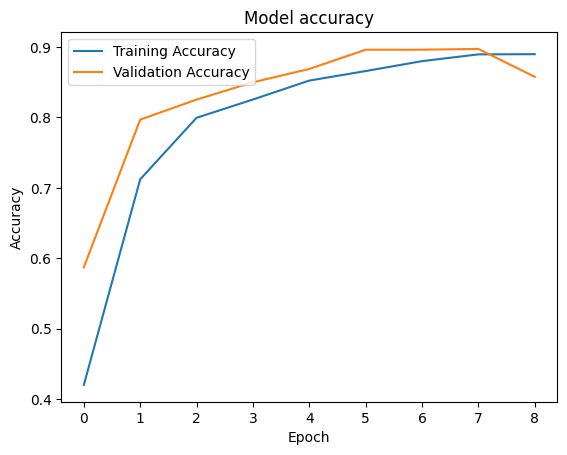

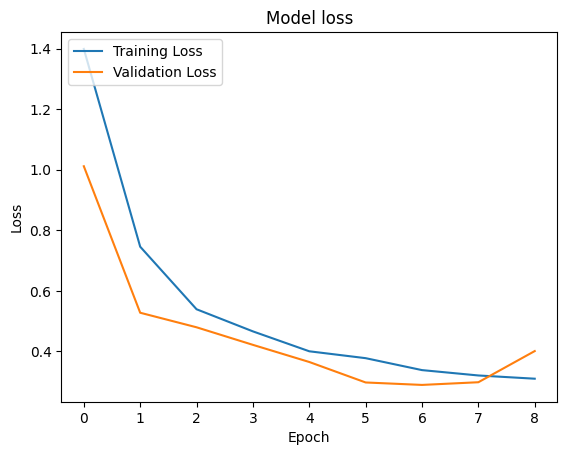

In [18]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot trainingy & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

<h3>Mô hình số 4</h3>

In [34]:
model = models.Sequential()

# Tầng tích chập đầu tiên
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ hai
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ ba
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng phân loại
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))  # Tăng số lượng units lên 256
model.add(layers.Dense(len(class_labels), activation='softmax'))

# Biên dịch mô hình
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Sử dụng cho bài toán phân loại đa lớp
              metrics=['accuracy'])

# In cấu trúc mô hình
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 111, 111, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 26, 26, 64)     

In [35]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=9,  # Số epoch bạn có thể tùy chỉnh
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_steps
)



Epoch 1/9
257/257 [==============================] - 64s 246ms/step - loss: 1.2325 - accuracy: 0.5057 - val_loss: 0.7067 - val_accuracy: 0.7528
Epoch 2/9
257/257 [==============================] - 59s 228ms/step - loss: 0.6957 - accuracy: 0.7383 - val_loss: 0.5621 - val_accuracy: 0.8069
Epoch 3/9
257/257 [==============================] - 60s 232ms/step - loss: 0.5610 - accuracy: 0.7932 - val_loss: 0.4605 - val_accuracy: 0.8354
Epoch 4/9
257/257 [==============================] - 61s 236ms/step - loss: 0.4557 - accuracy: 0.8374 - val_loss: 0.3747 - val_accuracy: 0.8817
Epoch 5/9
257/257 [==============================] - 58s 223ms/step - loss: 0.4125 - accuracy: 0.8537 - val_loss: 0.4426 - val_accuracy: 0.8387
Epoch 6/9
257/257 [==============================] - 57s 222ms/step - loss: 0.3739 - accuracy: 0.8680 - val_loss: 0.3691 - val_accuracy: 0.8633
Epoch 7/9
257/257 [==============================] - 59s 228ms/step - loss: 0.3298 - accuracy: 0.8844 - val_loss: 0.3072 - val_accuracy:

In [36]:
model.save('plant_recognition_model_4.h5')

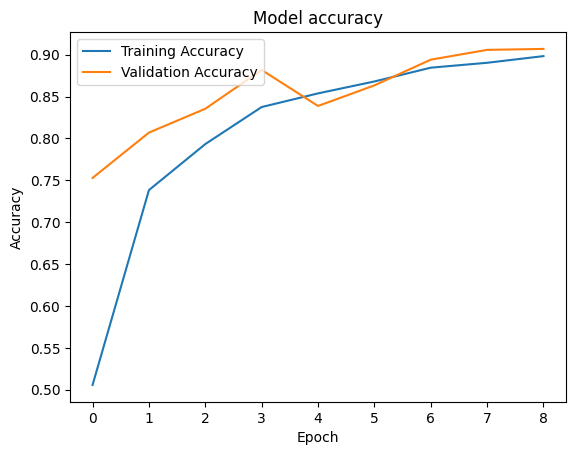

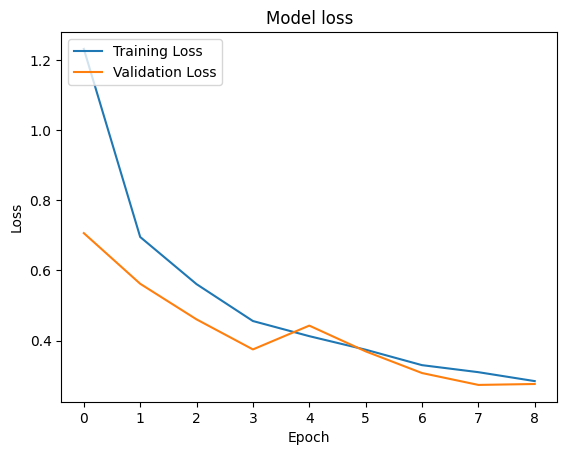

In [37]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot trainingy & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

<h3>Mô hình số 5</h3>

In [9]:
model = models.Sequential()

# Tầng tích chập đầu tiên
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ hai
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ ba
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Tầng tích chập thứ tư (mới thêm)
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


# Tầng phân loại
model.add(layers.Flatten())  # Làm phẳng dữ liệu từ ma trận 2D thành vector 1D
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(len(class_labels), activation='softmax'))  # Lớp softmax cho phân loại đa lớp

# Biên dịch mô hình
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Sử dụng cho bài toán phân loại đa lớp
              metrics=['accuracy'])

# In cấu trúc mô hình
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

In [10]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=9,  # Số epoch bạn có thể tùy chỉnh
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_steps
)



Epoch 1/9
257/257 [==============================] - 66s 248ms/step - loss: 1.4723 - accuracy: 0.3769 - val_loss: 1.0060 - val_accuracy: 0.6094
Epoch 2/9
257/257 [==============================] - 62s 239ms/step - loss: 0.8221 - accuracy: 0.6768 - val_loss: 0.6025 - val_accuracy: 0.7584
Epoch 3/9
257/257 [==============================] - 61s 236ms/step - loss: 0.5400 - accuracy: 0.8045 - val_loss: 0.4145 - val_accuracy: 0.8588
Epoch 4/9
257/257 [==============================] - 57s 222ms/step - loss: 0.4314 - accuracy: 0.8422 - val_loss: 0.4072 - val_accuracy: 0.8610
Epoch 5/9
257/257 [==============================] - 60s 234ms/step - loss: 0.3654 - accuracy: 0.8666 - val_loss: 0.3157 - val_accuracy: 0.8906
Epoch 6/9
257/257 [==============================] - 60s 231ms/step - loss: 0.3160 - accuracy: 0.8890 - val_loss: 0.2974 - val_accuracy: 0.8895
Epoch 7/9
257/257 [==============================] - 72s 280ms/step - loss: 0.2978 - accuracy: 0.8894 - val_loss: 0.2681 - val_accuracy:

In [11]:
model.save('plant_recognition_model_6.h5')

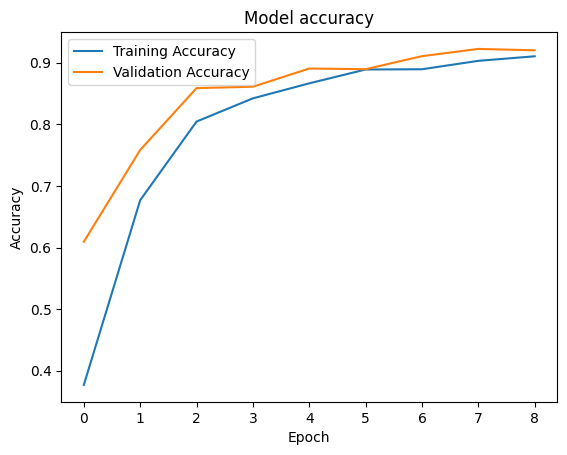

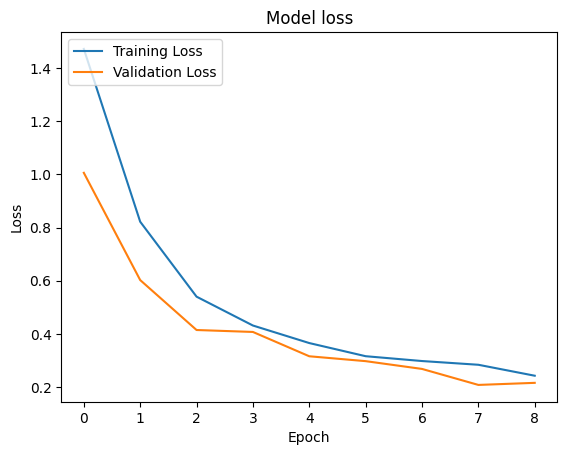

In [12]:
# Plot training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot trainingy & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()